In [1]:
import sys; sys.path.append('../3rdparty/ElasticRods/python')
import elastic_rods, elastic_knots
import numpy as np, matplotlib.pyplot as plt, time, io, os

from helpers import *
from parametric_curves import *
import py_newton_optimizer 

from linkage_vis import LinkageViewer as Viewer, CenterlineViewer
from tri_mesh_viewer import PointCloudViewer, PointCloudMesh

%load_ext autoreload
%autoreload 2

import parallelism
parallelism.set_max_num_tbb_threads(1)

In [2]:
file = "../data/L400-r0.2-UpTo9Crossings/4_1/0033.obj"
rod_radius = 0.2
material = elastic_rods.RodMaterial('ellipse', 2000, 0.3, [rod_radius, rod_radius])
centerline = read_nodes_from_file(file)[::4]  # supported formats: obj, txt
pr = define_periodic_rod(centerline, material)
rod_list = elastic_knots.PeriodicRodList([pr])

problemOptions = elastic_knots.ContactProblemOptions()
problemOptions.hasCollisions = True
problemOptions.contactStiffness = 1000
problemOptions.dHat = 2*rod_radius

contactProblem = elastic_knots.ContactProblem(rod_list,problemOptions)

print( f"Gradient length: {len(rod_list.gradient())},DoFs length: {len(rod_list.getDoFs())}")

Gradient length: 401,DoFs length: 401


In [3]:
loaded = np.load('Paths/optimizedpathAB2.npz')
path = [loaded[key] for key in loaded.files]
path = path[::2]
rod_list.setDoFs(path[0])
print(len(path))

72


In [4]:
view = Viewer(rod_list, width=1024, height=800)
view.show()

Renderer(camera=PerspectiveCamera(aspect=1.28, children=(PointLight(color='#999999', position=(0.0, 0.0, 5.0),…

In [5]:
def show_path(rod, path, view, wait=0.05):
    for DoFs in path:
        rod.setDoFs(DoFs)
        time.sleep(wait)
        view.update()


In [6]:
def getPathEnergy(path, rod, view):
    path_energy=[]
    for DoFs in path:
        rod.setDoFs(DoFs)
        path_energy.append(rod.energy())
        view.update()
    return path_energy
energy = getPathEnergy(path, contactProblem,view)

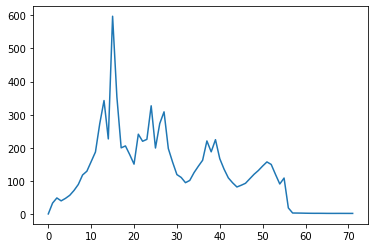

Path energy: 9127.054586068025


In [7]:
path_energy = getPathEnergy(path,contactProblem,view)
plt.plot(range(len(path_energy)),path_energy)
plt.show()
print(f"Path energy: {sum(path_energy)}")

In [8]:
time.sleep(3)
shortPath = path[28:31]
for Dof in shortPath:
    contactProblem.setDoFs(Dof)
    def callback(problem, iteration):
        if iteration % 20 == 0:
            view.update()

    fixedVars = []   # all the degrees of freedom can be modified by the optimizer
    optimizerOptions = py_newton_optimizer.NewtonOptimizerOptions()
    optimizerOptions.niter = 100000
    optimizerOptions.gradTol = 1e-8
    hessianShift = 1e-4 * compute_min_eigenval_straight_rod(pr)

    report = elastic_knots.compute_equilibrium(
    rod_list, problemOptions, optimizerOptions, 
    externalForces=np.zeros(rod_list.numDoF()),
    softConstraints=[],
    callback=callback,
    hessianShift=hessianShift
    )
    view.update()
    time.sleep(1)

0	198.04	41.7602	41.7602	1	1
1	157.981	23.7867	23.7867	1	1
2	142.144	16.9189	16.9189	1	1
3	130.549	8.27491	8.27491	1	1
4	128.804	7.13277	7.13277	1	1
5	126.487	6.14756	6.14756	1	1
6	125.63	5.78373	5.78373	1	1
7	124.189	5.20653	5.20653	1	1
8	123.611	4.96609	4.96609	1	1
9	122.476	4.54223	4.54223	1	1
10	120.933	3.88214	3.88214	1	1
11	119.711	3.44059	3.44059	1	1
12	118.364	3.24122	3.24122	1	1
13	116.54	3.1262	3.1262	1	1
14	113.875	3.18715	3.18715	1	1
15	109.734	5.10184	5.10184	0.5	1
16	106.087	11.9646	11.9646	1	1
17	104.895	3.84264	3.84264	1	1
18	102.874	3.21533	3.21533	1	1
19	98.7527	5.60439	5.60439	1	1
20	92.0776	15.3295	15.3295	1	1
21	82.9651	19.7431	19.7431	1	1
22	74.4291	40.6838	40.6838	0.0078125	1
23	74.2688	39.9514	39.9514	1	1
24	70.2404	8.94936	8.94936	1	1
25	69.1937	3.35975	3.35975	1	1
26	67.5199	2.92812	2.92812	1	1
27	64.5298	4.77049	4.77049	1	1
28	60.1067	10.6627	10.6627	1	1
29	59.0877	2.85446	2.85446	1	1
30	57.8546	2.59262	2.59262	1	1
31	55.6898	12.7306	12.7306	1	1
32	53.3455	68

249	6.03698	0.341639	0.341639	1	1
250	5.89049	0.700934	0.700934	0.0117188	1
251	5.88873	0.885485	0.885485	1	1
252	5.83978	0.135209	0.135209	1	1
253	5.75773	0.394759	0.394759	1	1
254	5.61374	0.631267	0.631267	0.0117188	1
255	5.61174	0.778828	0.778828	1	1
256	5.56465	0.121436	0.121436	1	1
257	5.48463	0.344905	0.344905	1	1
258	5.34382	0.593725	0.593725	1	1
259	5.13104	0.972132	0.972132	0.5	1
260	4.99128	2.62808	2.62808	1	1
261	4.96031	0.610271	0.610271	1	1
262	4.94914	0.157587	0.157587	1	1
263	4.92948	0.073946	0.073946	1	1
264	4.89147	0.158505	0.158505	1	1
265	4.81891	0.241847	0.241847	1	1
266	4.69245	0.503906	0.503906	1	1
267	4.50502	0.807456	0.807456	0.0703125	0
268	4.43591	2.94842	2.94842	1	1
269	4.39584	0.706993	0.706993	1	1
270	4.39142	0.908547	0.908547	1	1
271	4.3805	0.22571	0.22571	1	1
272	4.36349	0.0759783	0.0759783	1	1
273	4.33076	0.0779096	0.0779096	1	1
274	4.2685	0.169184	0.169184	1	1
275	4.15912	0.385571	0.385571	1	1
276	3.99726	0.696772	0.696772	0.09375	0
277	3.93018	4.31763	

474	1.19434	0.0214879	0.0214879	1	1
475	1.18543	0.0556757	0.0556757	1	1
476	1.17371	0.967172	0.967172	1	1
477	1.17011	0.236208	0.236208	1	1
478	1.16951	0.0572899	0.0572899	1	1
479	1.16896	0.0141277	0.0141277	1	1
480	1.16792	0.00713906	0.00713906	1	1
481	1.16589	0.0078067	0.0078067	1	1
482	1.16194	0.0142335	0.0142335	1	1
483	1.15449	0.0385628	0.0385628	0.00195312	1
484	1.15446	0.0396612	0.0396612	1	1
485	1.13503	0.3051	0.3051	0.03125	1
486	1.13408	0.332248	0.332248	0.25	1
487	1.13376	0.482036	0.482036	0.0625	1
488	1.13223	0.4519	0.4519	0.015625	1
489	1.13176	0.444832	0.444832	0.00390625	1
490	1.13164	0.442502	0.442502	0.75	1
491	1.1064	0.262073	0.262073	0.000488281	0
492	1.10637	0.260921	0.260921	0.015625	0
493	1.10561	0.256904	0.256904	0.09375	0
494	1.10132	0.249636	0.249636	0.046875	0
495	1.0992	0.238403	0.238403	0.00585938	0
496	1.09893	0.237015	0.237015	0.00390625	0
497	1.09891	0.28325	0.28325	1	1
498	1.08829	0.249134	0.249134	0.25	1
499	1.08759	0.188114	0.188114	0.03125	1
500	1.087

683	0.915144	0.700771	0.700771	1	1
684	0.912422	0.188743	0.188743	1	1
685	0.912233	0.110211	0.110211	1	1
686	0.912129	0.0265376	0.0265376	1	1
687	0.912101	0.00592148	0.00592148	1	1
688	0.912067	0.00133382	0.00133382	1	1
689	0.912001	0.000881242	0.000881242	1	1
690	0.91187	0.000943437	0.000943437	1	1
691	0.911609	0.00152214	0.00152214	1	1
692	0.911095	0.00423065	0.00423065	1	1
693	0.910104	0.010977	0.010977	0.00146484	1
694	0.910101	0.0121139	0.0121139	1	1
695	0.907465	0.0954439	0.0954439	0.00012207	0
696	0.907458	0.0950816	0.0950816	0.000244141	0
697	0.907456	0.0957813	0.0957813	0.015625	1
698	0.907355	0.0942546	0.0942546	0.5	1
699	0.9065	0.282159	0.282159	0.00195312	0
700	0.906415	0.281579	0.281579	0.0234375	0
701	0.905945	0.274966	0.274966	0.0078125	0
702	0.905789	0.272817	0.272817	0.00390625	0
703	0.905711	0.271751	0.271751	0.000488281	0
704	0.905702	0.271364	0.271364	1	0
705	0.901791	0.217605	0.217605	0.000976562	0
706	0.901739	0.217387	0.217387	0.000244141	0
707	0.901728	0.21717	0

887	0.812119	0.0312689	0.0312689	1	1
888	0.811476	0.0341177	0.0341177	0.00012207	0
889	0.811472	0.0339485	0.0339485	1	0
890	0.810885	0.0614228	0.0614228	0.000244141	0
891	0.81088	0.0614078	0.0614078	0.00012207	0
892	0.81088	0.0614952	0.0614952	1	0
893	0.810031	0.0204226	0.0204226	7.62939e-06	0
894	0.810029	0.0203023	0.0203023	0.5	0
895	0.80975	0.0628999	0.0628999	6.10352e-05	0
896	0.809749	0.0628456	0.0628456	1	0
897	0.808979	0.0350294	0.0350294	0.000244141	1
898	0.808978	0.0349726	0.0349726	0.25	0
899	0.808733	0.0475502	0.0475502	0.00012207	0
900	0.808731	0.0475718	0.0475718	1	0
901	0.808142	0.0290292	0.0290292	2.28882e-05	0
902	0.80814	0.0291475	0.0291475	0.5	0
903	0.808016	0.0596538	0.0596538	0.000244141	0
904	0.808012	0.0596392	0.0596392	6.10352e-05	0
905	0.808011	0.0596061	0.0596061	1	0
906	0.807394	0.046753	0.046753	0.125	0
907	0.807264	0.0433441	0.0433441	1	0
908	0.806885	0.0437721	0.0437721	6.10352e-05	0
909	0.806884	0.0437179	0.0437179	0.0625	0
910	0.806843	0.0495518	0.0495518

98	9.27581	3.51096	3.51096	1	1
99	9.24871	0.871127	0.871127	1	1
100	9.23816	0.260193	0.260193	1	1
101	9.22165	0.157629	0.157629	1	1
102	9.18974	0.151315	0.151315	1	1
103	9.12799	0.172097	0.172097	1	1
104	9.01206	0.333049	0.333049	1	1
105	8.81181	0.846886	0.846886	1	1
106	8.51673	1.37266	1.37266	0.125	1
107	8.50979	3.60229	3.60229	1	1
108	8.45434	0.569644	0.569644	1	1
109	8.40819	0.200247	0.200247	1	1
110	8.32238	0.269989	0.269989	0.5	1
111	8.3042	7.9698	7.9698	1	1
112	8.24519	1.73365	1.73365	1	1
113	8.22991	0.429898	0.429898	1	1
114	8.20963	0.150226	0.150226	1	1
115	8.17104	0.126164	0.126164	1	1
116	8.10211	1.65139	1.65139	1	1
117	8.06252	0.357234	0.357234	1	1
118	7.99431	0.18076	0.18076	1	1
119	7.86882	0.381703	0.381703	0.0625	1
120	7.85435	0.620108	0.620108	1	1
121	7.84343	0.122094	0.122094	0.25	1
122	7.84075	0.955666	0.955666	1	1
123	7.83733	0.251939	0.251939	1	1
124	7.83303	0.115966	0.115966	1	1
125	7.82477	0.10798	0.10798	1	1
126	7.8084	0.109668	0.109668	0.25	1
127	7.80304	1.42125

330	2.37188	0.408692	0.408692	1	1
331	2.36543	0.14875	0.14875	1	1
332	2.3572	0.0436544	0.0436544	1	1
333	2.34194	0.0436435	0.0436435	1	1
334	2.31258	0.128104	0.128104	1	1
335	2.26244	0.293236	0.293236	1	1
336	2.19105	0.399822	0.399822	1	1
337	2.10465	0.5253	0.5253	0.00146484	0
338	2.1043	0.521861	0.521861	1	1
339	2.00753	0.703076	0.703076	0.00292969	0
340	2.00685	0.701017	0.701017	0.00146484	0
341	2.00653	0.697671	0.697671	0.6875	0
342	1.92375	0.815125	0.815125	0.0078125	0
343	1.92228	0.814806	0.814806	1	1
344	1.82531	0.316239	0.316239	0.015625	0
345	1.81887	0.311	0.311	0.000183105	0
346	1.8188	0.309939	0.309939	0.125	1
347	1.80263	0.281791	0.281791	0.000976562	0
348	1.80227	0.281517	0.281517	0.000244141	0
349	1.80219	0.283062	0.283062	0.15625	1
350	1.78361	1.32661	1.32661	1	1
351	1.77609	0.295452	0.295452	1	1
352	1.77471	0.076279	0.076279	1	1
353	1.77289	0.0239579	0.0239579	1	1
354	1.76947	0.021789	0.021789	1	1
355	1.7629	0.0241872	0.0241872	1	1
356	1.75029	0.05143	0.05143	1	1
357	1.7

548	0.949392	0.00470118	0.00470118	1	1
549	0.946535	0.0409849	0.0409849	0.00585938	1
550	0.946475	0.0407454	0.0407454	0.00195312	1
551	0.946449	0.0409106	0.0409106	0.3125	1
552	0.944832	0.0392081	0.0392081	0.00390625	1
553	0.944772	0.0390569	0.0390569	0.000976562	1
554	0.944751	0.0379052	0.0379052	0.0078125	1
555	0.944597	0.0377337	0.0377337	0.000732422	1
556	0.944579	0.0414336	0.0414336	0.09375	1
557	0.943308	0.437725	0.437725	1	1
558	0.941387	0.431977	0.431977	1	1
559	0.940707	0.104892	0.104892	1	1
560	0.940596	0.0248599	0.0248599	1	1
561	0.940525	0.00567596	0.00567596	1	1
562	0.940411	0.0024744	0.0024744	1	1
563	0.940201	0.00231434	0.00231434	0.25	1
564	0.940125	0.0453701	0.0453701	1	1
565	0.939514	0.0105432	0.0105432	1	1
566	0.938599	0.159043	0.159043	1	1
567	0.93797	0.0386617	0.0386617	1	1
568	0.936963	0.012156	0.012156	1	1
569	0.935137	0.0170776	0.0170776	1	1
570	0.932164	0.043046	0.043046	0.000366211	0
571	0.932156	0.060705	0.060705	1	1
572	0.931541	0.00696798	0.00696798	1	1
573

751	0.828992	0.152974	0.152974	1	1
752	0.828828	0.0378065	0.0378065	1	1
753	0.82879	0.00922292	0.00922292	1	1
754	0.828752	0.00218632	0.00218632	1	1
755	0.828682	0.000710421	0.000710421	1	1
756	0.828545	0.00078644	0.00078644	1	1
757	0.828283	0.00202426	0.00202426	1	1
758	0.827763	0.011428	0.011428	0.25	1
759	0.827502	0.00940905	0.00940905	0.000488281	1
760	0.827498	0.00881786	0.00881786	0.5	1
761	0.826944	0.420911	0.420911	0.5	1
762	0.826436	0.285801	0.285801	1	1
763	0.825934	0.0702557	0.0702557	1	1
764	0.825879	0.016682	0.016682	1	1
765	0.82587	0.00347901	0.00347901	1	1
766	0.825862	0.000737246	0.000737246	1	1
767	0.825846	0.000577837	0.000577837	1	1
768	0.825816	0.000574964	0.000574964	1	1
769	0.825757	0.000585394	0.000585394	1	1
770	0.825639	0.000713462	0.000713462	1	1
771	0.825409	0.00163527	0.00163527	1	1
772	0.824963	0.00556893	0.00556893	0.125	1
773	0.824867	0.023864	0.023864	1	1
774	0.823922	0.172333	0.172333	0.5	1
775	0.823596	0.101365	0.101365	1	1
776	0.823406	0.033555	0.0335

29	39.0807	1.96356	1.96356	1	1
30	38.5361	1.85989	1.85989	1	1
31	38.4085	1.82125	1.82125	1	1
32	38.1582	2.48196	2.48196	1	1
33	37.6778	1.744	1.744	1	1
34	36.7754	1.81419	1.81419	1	1
35	35.1979	2.97923	2.97923	1	1
36	32.919	5.06219	5.06219	1	1
37	30.9136	22.7743	22.7743	1	1
38	29.2046	4.1297	4.1297	1	1
39	28.8895	1.53366	1.53366	1	1
40	28.3859	1.33358	1.33358	1	1
41	27.441	2.01737	2.01737	1	1
42	26.0457	3.76603	3.76603	1	1
43	24.0299	6.5217	6.5217	1	1
44	21.7309	10.911	10.911	1	1
45	20.2303	3.16083	3.16083	1	1
46	18.7264	10.947	10.947	1	1
47	16.4676	5.22824	5.22824	0.75	1
48	14.9281	6.78783	6.78783	0.046875	1
49	14.8025	6.47677	6.47677	0.015625	1
50	14.7876	8.04354	8.04354	1	1
51	14.4252	1.53436	1.53436	1	1
52	14.3254	0.612314	0.612314	1	1
53	14.167	0.53369	0.53369	1	1
54	13.8811	0.735713	0.735713	1	1
55	13.3949	1.60907	1.60907	1	1
56	12.6671	3.32157	3.32157	0.03125	1
57	12.6576	5.57968	5.57968	1	1
58	12.4997	0.502665	0.502665	1	1
59	12.3765	0.473792	0.473792	1	1
60	12.1318	0.820951	0.8

266	2.09607	0.0337036	0.0337036	0.125	1
267	2.09555	1.15633	1.15633	1	1
268	2.09152	0.283502	0.283502	1	1
269	2.08914	0.0724027	0.0724027	1	1
270	2.0851	0.025575	0.025575	1	1
271	2.07722	0.0210254	0.0210254	1	1
272	2.06207	0.144368	0.144368	0.25	1
273	2.05721	0.857183	0.857183	1	1
274	2.05417	0.211316	0.211316	1	1
275	2.05206	0.0546233	0.0546233	1	1
276	2.04835	0.0224102	0.0224102	1	1
277	2.04109	0.0200026	0.0200026	1	1
278	2.02697	0.0275698	0.0275698	1	1
279	2.00243	0.793374	0.793374	0.25	1
280	2.00165	0.641414	0.641414	1	1
281	1.99834	0.147252	0.147252	1	1
282	1.99484	0.0399998	0.0399998	1	1
283	1.98825	0.0200074	0.0200074	1	1
284	1.9754	0.0247271	0.0247271	1	1
285	1.95086	0.0591988	0.0591988	0.00976562	1
286	1.95062	0.200662	0.200662	1	1
287	1.92684	0.278732	0.278732	0.03125	1
288	1.92532	0.269768	0.269768	1	1
289	1.85653	0.614289	0.614289	1	1
290	1.8121	0.101294	0.101294	0.00585938	1
291	1.81172	0.132126	0.132126	0.25	1
292	1.78204	1.00746	1.00746	0.5	1
293	1.77571	0.603889	0.60388

482	0.936655	0.0148611	0.0148611	1	1
483	0.936415	0.00350125	0.00350125	1	1
484	0.935958	0.00280592	0.00280592	1	1
485	0.935083	0.00523561	0.00523561	1	1
486	0.933446	0.0125831	0.0125831	0.0625	1
487	0.933332	0.101179	0.101179	1	1
488	0.93284	0.00698593	0.00698593	1	1
489	0.932037	0.00553276	0.00553276	1	1
490	0.930554	0.0105299	0.0105299	1	1
491	0.92892	0.615891	0.615891	1	1
492	0.928052	0.258887	0.258887	1	1
493	0.927877	0.101733	0.101733	1	1
494	0.927675	0.0234964	0.0234964	1	1
495	0.927496	0.00537912	0.00537912	1	1
496	0.927166	0.00217528	0.00217528	1	1
497	0.926524	0.00276945	0.00276945	1	1
498	0.925304	0.00724553	0.00724553	1	1
499	0.923117	0.021749	0.021749	0.0078125	1
500	0.923087	0.0276805	0.0276805	1	1
501	0.919015	0.123702	0.123702	0.000976562	1
502	0.919002	0.122901	0.122901	0.15625	1
503	0.91724	0.162176	0.162176	0.000488281	0
504	0.917237	0.163278	0.163278	0.1875	1
505	0.916341	0.209855	0.209855	1	1
506	0.914925	0.0348889	0.0348889	1	1
507	0.914652	0.0109756	0.0109756	1	1

In [69]:
contactProblem.setDoFs(shortPath[0])
ASaddlePath = []
def callback(problem, iteration):
        if iteration % 20 == 0:
            ASaddlePath.append(rod_list.getDoFs())
            view.update()

report = elastic_knots.compute_equilibrium(
rod_list, problemOptions, optimizerOptions, 
externalForces=np.zeros(rod_list.numDoF()),
softConstraints=[],
callback=callback,
hessianShift=hessianShift
)
view.update()
time.sleep(1)
ASaddlePath = ASaddlePath[-1::-1]

0	276.324	51.8058	51.8058	1	1
1	262.753	46.7201	46.7201	1	1
2	239.847	37.2179	37.2179	1	1
3	230.633	34.3669	34.3669	1	1
4	211.813	28.7963	28.7963	1	1
5	184.457	21.2341	21.2341	0.125	1
6	175.885	22.2763	22.2763	1	1
7	157.073	16.1774	16.1774	1	1
8	143.731	11.067	11.067	1	1
9	134.775	7.6786	7.6786	1	1
10	128.312	5.39932	5.39932	1	1
11	123.962	4.20523	4.20523	1	1
12	120.415	3.56014	3.56014	1	1
13	117.627	3.18791	3.18791	1	1
14	114.595	3.1688	3.1688	1	1
15	110.708	4.89514	4.89514	1	1
16	103.287	13.5631	13.5631	0.25	1
17	101.43	50.5216	50.5216	1	1
18	99.7592	13.5858	13.5858	1	1
19	99.2433	4.6185	4.6185	1	1
20	98.651	3.21672	3.21672	1	1
21	97.5357	3.13826	3.13826	1	1
22	95.3114	3.36633	3.36633	1	1
23	90.9525	6.11976	6.11976	1	1
24	84.3149	14.4267	14.4267	1	1
25	76.3343	23.576	23.576	1	1
26	74.4244	5.39183	5.39183	1	1
27	73.4068	3.01627	3.01627	1	1
28	71.5637	3.04841	3.04841	1	1
29	68.5018	4.63723	4.63723	1	1
30	63.8686	12.0869	12.0869	1	1
31	62.8292	2.90874	2.90874	1	1
32	61.5305	2.54874	2.54

In [70]:

print(len(ASaddlePath))

51


In [71]:
contactProblem.setDoFs(shortPath[-1])
SaddleBPath = []
def callback(problem, iteration):
        if iteration % 20 == 0:
            SaddleBPath.append(rod_list.getDoFs())
            view.update()

report = elastic_knots.compute_equilibrium(
rod_list, problemOptions, optimizerOptions, 
externalForces=np.zeros(rod_list.numDoF()),
softConstraints=[],
callback=callback,
hessianShift=hessianShift
)
view.update()
time.sleep(1)

0	278.034	31.195	31.195	1	1
1	244.344	26.5191	26.5191	1	1
2	203.076	20.048	20.048	1	1
3	159.515	14.2507	14.2507	1	1
4	152.231	11.5343	11.5343	1	1
5	121.726	10.0255	10.0255	1	1
6	103.933	6.40559	6.40559	1	1
7	101.861	6.02249	6.02249	1	1
8	100.943	5.94082	5.94082	1	1
9	98.0997	6.09933	6.09933	0.0625	1
10	96.8155	7.42891	7.42891	1	1
11	92.36	3.89387	3.89387	1	1
12	90.202	3.39903	3.39903	1	1
13	90.0315	4.74868	4.74868	1	1
14	86.0997	3.07203	3.07203	1	1
15	83.1116	3.43984	3.43984	1	1
16	78.9181	7.6155	7.6155	0.125	1
17	77.8377	7.17043	7.17043	1	1
18	72.7787	5.35846	5.35846	1	1
19	66.6146	16.2178	16.2178	1	1
20	58.8631	17.1784	17.1784	1	1
21	57.1312	47.0758	47.0758	1	1
22	44.3716	4.66481	4.66481	1	1
23	41.1839	21.6328	21.6328	0.5	1
24	39.9144	8.05566	8.05566	1	1
25	39.2161	2.18592	2.18592	1	1
26	38.6342	1.86131	1.86131	1	1
27	37.5936	2.0251	2.0251	1	1
28	35.9178	14.8746	14.8746	1	1
29	35.7722	2.18091	2.18091	1	1
30	35.6592	1.62744	1.62744	1	1
31	35.4497	1.5877	1.5877	1	1
32	35.0474	1.5592	1.

In [72]:
print(len(SaddleBPath))

43


In [73]:
finalPath = ASaddlePath + shortPath + SaddleBPath
print(len(finalPath))

97


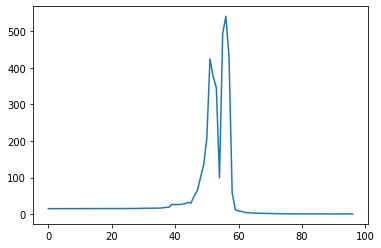

Path energy: 4217.649511163251


In [75]:
path_energy = getPathEnergy(finalPath,contactProblem,view)
plt.plot(range(len(path_energy)),path_energy)
plt.show()
print(f"Path energy: {sum(path_energy)}")

In [76]:
np.savez('ASaddleBpath.npz', *finalPath)